In [1]:
import gym
import pygame
import time
import matplotlib.pyplot as plt
import numpy as np
from dqn import DQN
from keras.utils import plot_model
from collections import deque

In [2]:
num_episodes = 100
target_update_frequency = 1000
max_steps_per_episode = 10000
y = 1.0  # discount factor
initial_epsilon = 1.0
final_epsilon = 0.1
batch_size = 8
blend = 4
skip_start = 65

epsilon_decay_rate = (initial_epsilon - final_epsilon) / num_episodes
epsilon = initial_epsilon
stats_check = max(num_episodes // 100, 1)

reward_history = ([], [])
loss_history = ([], [])

c:\Users\guybo\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


Loaded weights


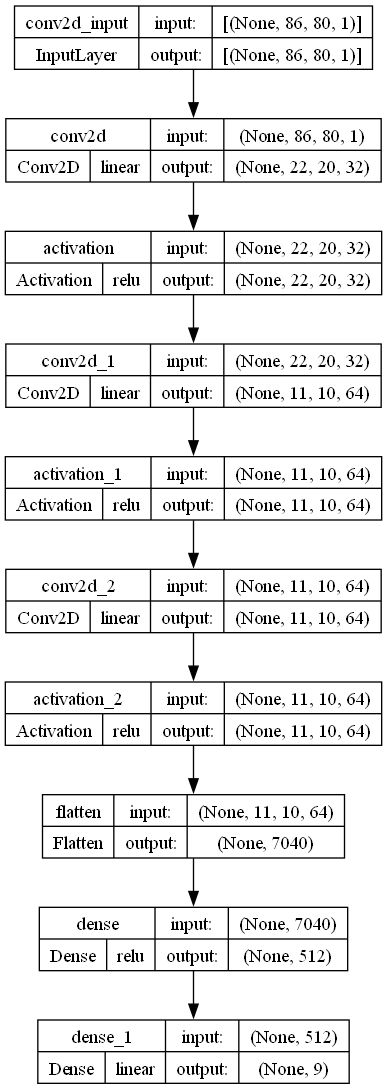

In [3]:
env = gym.make(
    "ALE/MsPacman-v5",
    full_action_space=False,
    obs_type="grayscale",
    # render_mode="human",
)  # Create the environment
agent = DQN((86, 80, 1), env.action_space.n, y, r".\pacman_agent_ale", 100000)
plot_model(agent.q_network, show_shapes=True, show_layer_activations=True)

In [4]:
# Helpful preprocessing taken from github.com/ageron/tiny-dqn
def process_frame(frame):
    mspacman_color = 167
    img = frame[1:172:2, ::2]  # Crop and downsize
    img[img == mspacman_color] = 255  # Improve contrast by making pacman white
    img = img / 128.0  # Normalize from -1 to 1.
    img -= 1

    return img.reshape(86, 80, 1)

In [5]:
def blend_images(images, blend):
    avg_image = np.zeros((86, 80, 1), np.float64)

    for image in images:
        avg_image += image

    if len(images) < blend:
        return avg_image / len(images)
    else:
        return avg_image / blend

In [6]:
closed = False
steps = 0
loss_sum = 0
total_reward = 0
epoch_steps = 0
start_time = time.time()

for episode in range(1, num_episodes + 1):
    state = process_frame(env.reset()[0])
    images = deque(maxlen=blend)  # Array of images to be blended
    images.append(state)

    for skip in range(skip_start):  # skip the start of each game
        env.step(0)

    print("starting")
    for step in range(1, max_steps_per_episode + 1):
        state = blend_images(images, blend)
        action = agent.predict_action(state, env, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        if info["lives"] < 3:
            reward = -10
        reward -= 1

        next_state = process_frame(next_state)

        images.append(next_state)
        next_state = blend_images(images, blend)

        """print(next_state.shape)
        image = Image.fromarray(
            ((next_state.reshape(86, 80) * 128) + 128).astype(np.uint8)
        )
        image.show()"""

        agent.add_data(state, action, reward, next_state, terminated)

        state = next_state
        total_reward += reward

        if len(agent.replay_memory) >= batch_size:
            loss = agent.train_on_batch(batch_size)
            loss_sum += loss

        steps += 1
        epoch_steps += 1
        if steps % target_update_frequency == 0:
            agent.update_target_model()

        if terminated or truncated or closed or info["lives"] < 3:
            break
        # Update epsilon for the next episode
    epsilon -= epsilon_decay_rate
    epsilon = max(
        final_epsilon, epsilon
    )  # Ensure epsilon doesn't go below the final value
    if episode % stats_check == 0:
        average_reward = total_reward / stats_check
        average_loss = loss_sum / stats_check
        print(
            f"Episods done: {episode}, average reward: {average_reward:.1f}, average loss: {average_loss}"
        )
        loss_history[0].append(episode)
        loss_history[1].append(average_loss)
        reward_history[0].append(episode)
        reward_history[1].append(average_reward)
        total_reward = 0
        loss_sum = 0
    if closed:
        break

starting


c:\Users\guybo\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episods done: 1, average reward: -6.0, average loss: 115.59789276123047
starting
Episods done: 2, average reward: -22.0, average loss: 83.10409545898438
starting
Episods done: 3, average reward: -4.0, average loss: 129.048095703125
starting
Episods done: 4, average reward: -30.0, average loss: 197.1203155517578
starting
Episods done: 5, average reward: -54.0, average loss: 153.31832885742188
starting
Episods done: 6, average reward: -70.0, average loss: 144.69627380371094
starting
Episods done: 7, average reward: -42.0, average loss: 110.22602081298828
starting
Episods done: 8, average reward: -36.0, average loss: 143.33013916015625
starting
Episods done: 9, average reward: -74.0, average loss: 237.1995849609375
starting
Episods done: 10, average reward: -16.0, average loss: 112.12812042236328
starting
Episods done: 11, average reward: -36.0, average loss: 235.92523193359375
starting
Episods done: 12, average reward: -26.0, average loss: 236.66796875
starting
Episods done: 13, average 

In [7]:
print(len(agent.replay_memory))

12388


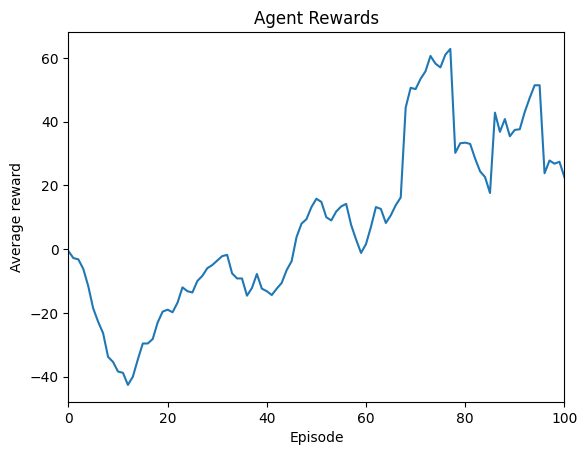

In [9]:
# Rewards
if reward_history[0]:
    y = np.convolve(reward_history[1], np.ones(10) / 10)
    plt.plot(y)
    plt.title("Agent Rewards")
    plt.ylabel("Average reward")
    plt.xlabel("Episode")
    plt.ylim()
    plt.xlim(left=0, right=num_episodes)
    plt.show()

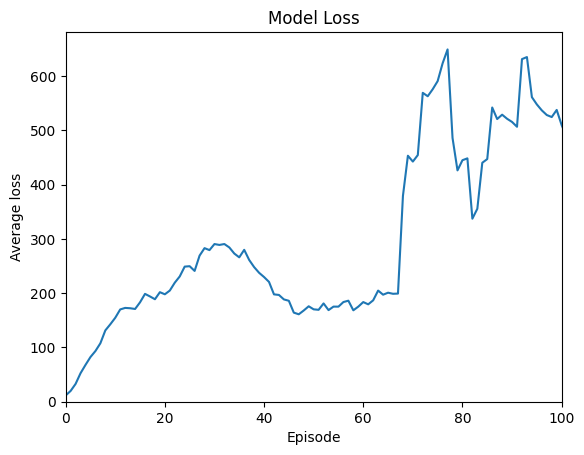

In [10]:
# Loss
if loss_history[0]:
    y = np.convolve(loss_history[1], np.ones(10) / 10)
    plt.plot(y)
    plt.title("Model Loss")
    plt.ylabel("Average loss")
    plt.xlabel("Episode")
    plt.ylim(bottom=0)
    plt.xlim(left=0, right=num_episodes)
    plt.show()

In [11]:
env = gym.make(
    "ALE/MsPacman-v5",
    full_action_space=False,
    obs_type="grayscale",
    render_mode="human",
)
closed = False

while not closed:
    state = process_frame(env.reset()[0])
    images = deque(maxlen=blend)  # Array of images to be blended
    images.append(state)

    while True:
        state = blend_images(images, blend)
        action = agent.predict_action(state, env, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        if info["lives"] < 3:
            reward = -10
        print(reward - 1, info)

        next_state = process_frame(next_state)
        images.append(next_state)
        next_state = blend_images(images, blend)
        state = next_state

        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN and event.key == pygame.K_g:
                closed = True
                break

        if terminated or truncated or closed or info["lives"] < 3:
            break
    if closed:
        break

0.0 {'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}
0.0 {'lives': 3, 'episode_frame_number': 8, 'frame_number': 8}
0.0 {'lives': 3, 'episode_frame_number': 12, 'frame_number': 12}
0.0 {'lives': 3, 'episode_frame_number': 16, 'frame_number': 16}
0.0 {'lives': 3, 'episode_frame_number': 20, 'frame_number': 20}
0.0 {'lives': 3, 'episode_frame_number': 24, 'frame_number': 24}
0.0 {'lives': 3, 'episode_frame_number': 28, 'frame_number': 28}
0.0 {'lives': 3, 'episode_frame_number': 32, 'frame_number': 32}
0.0 {'lives': 3, 'episode_frame_number': 36, 'frame_number': 36}
0.0 {'lives': 3, 'episode_frame_number': 40, 'frame_number': 40}
0.0 {'lives': 3, 'episode_frame_number': 44, 'frame_number': 44}
0.0 {'lives': 3, 'episode_frame_number': 48, 'frame_number': 48}
0.0 {'lives': 3, 'episode_frame_number': 52, 'frame_number': 52}
0.0 {'lives': 3, 'episode_frame_number': 56, 'frame_number': 56}
0.0 {'lives': 3, 'episode_frame_number': 60, 'frame_number': 60}
0.0 {'lives': 3, 'episode_fra

In [12]:
agent.save_data()